In [1]:
%pip install torch torchvision torchaudio
%pip install pillow matplotlib numpy timm scikit-learn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import timm

device = torch.device("mps")
print(f"Using device: {device}")

# Training was at 384x384, but we can use higher res for inference via pos_embed interpolation
TRAIN_SIZE = 384  # Size model was trained at
INFERENCE_SIZE = 1600  # Higher resolution for inference (must be divisible by 16)

transform = transforms.Compose([
    transforms.Resize((INFERENCE_SIZE, INFERENCE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def interpolate_pos_embed(model, new_size):
    """Interpolate positional embeddings to support different input sizes"""
    pos_embed = model.pos_embed
    num_extra_tokens = 1  # CLS token
    
    # Calculate grid sizes
    old_size = int((pos_embed.shape[1] - num_extra_tokens) ** 0.5)
    new_grid_size = new_size // 16  # patch size is 16
    
    if old_size == new_grid_size:
        return  # No interpolation needed
    
    print(f"  Interpolating pos_embed: {old_size}x{old_size} -> {new_grid_size}x{new_grid_size}")
    
    # Extract and reshape
    cls_token = pos_embed[:, :num_extra_tokens]
    pos_tokens = pos_embed[:, num_extra_tokens:]
    pos_tokens = pos_tokens.reshape(1, old_size, old_size, -1).permute(0, 3, 1, 2)
    
    # Interpolate
    pos_tokens = torch.nn.functional.interpolate(
        pos_tokens, size=(new_grid_size, new_grid_size), 
        mode='bicubic', align_corners=False
    )
    pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
    
    # Concatenate back
    new_pos_embed = torch.cat([cls_token, pos_tokens], dim=1)
    model.pos_embed = torch.nn.Parameter(new_pos_embed)
    
    # Update model's internal size parameters
    model.patch_embed.img_size = (new_size, new_size)
    model.patch_embed.grid_size = (new_grid_size, new_grid_size)
    model.patch_embed.num_patches = new_grid_size * new_grid_size

def load_model(checkpoint_path=None, inference_size=INFERENCE_SIZE):
    """Load base or finetuned DINOv3 model"""
    # Determine checkpoint resolution if loading from checkpoint
    checkpoint_size = TRAIN_SIZE
    
    if checkpoint_path:
        state_dict = torch.load(checkpoint_path, map_location=device)
        # For finetuned model, extract 'student' key from checkpoint
        if 'student' in state_dict:
            state_dict = state_dict['student']
        elif 'model' in state_dict:
            state_dict = state_dict['model']
        elif 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']
        
        # Detect checkpoint resolution from pos_embed shape
        if 'pos_embed' in state_dict:
            num_patches = state_dict['pos_embed'].shape[1] - 1  # Subtract CLS token
            grid_size = int(num_patches ** 0.5)
            checkpoint_size = grid_size * 16  # patch size is 16
            print(f"Detected checkpoint trained at: {checkpoint_size}x{checkpoint_size}")
    
    # Create model at checkpoint resolution
    model = timm.create_model('vit_large_patch16_384', pretrained=False, num_classes=0, img_size=checkpoint_size)
    
    if checkpoint_path:
        model.load_state_dict(state_dict, strict=False)
    
    # Interpolate positional embeddings to inference resolution
    if inference_size != checkpoint_size:
        interpolate_pos_embed(model, inference_size)
    
    model = model.to(device)
    model.eval()
    return model

def extract_features(model, img_path):
    """Extract dense features from an image"""
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = model.forward_features(img_tensor)
        if len(features.shape) == 3:
            features = features[:, 1:, :]  # Remove CLS token
    
    return features.squeeze().cpu().numpy(), img

def features_to_pca_rgb(features):
    """Convert features to RGB using PCA"""
    features_flat = features.reshape(-1, features.shape[-1])
    
    pca = PCA(n_components=3)
    features_pca = pca.fit_transform(features_flat)
    
    # Normalize to [0, 1]
    for i in range(3):
        channel = features_pca[:, i]
        channel_min, channel_max = channel.min(), channel.max()
        if channel_max > channel_min:
            features_pca[:, i] = (channel - channel_min) / (channel_max - channel_min)
    
    h_patches = w_patches = INFERENCE_SIZE // 16  # 960//16 = 60
    return features_pca.reshape(h_patches, w_patches, 3)

def visualize_comparison(image_paths, base_model, finetuned_model, title):
    """Generate comparison plots: original, base PCA, finetuned PCA"""
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    fig.suptitle(title, fontsize=16)
    
    for i, img_path in enumerate(image_paths[:6]):
        # Extract features
        base_features, original_img = extract_features(base_model, img_path)
        finetuned_features, _ = extract_features(finetuned_model, img_path)
        
        # Convert to RGB via PCA
        base_rgb = features_to_pca_rgb(base_features)
        finetuned_rgb = features_to_pca_rgb(finetuned_features)
        
        # Plot original
        axes[0, i].imshow(original_img)
        axes[0, i].set_title(f'{Path(img_path).name[:12]}', fontsize=8)
        axes[0, i].axis('off')
        
        # Plot base model PCA
        axes[1, i].imshow(base_rgb)
        axes[1, i].axis('off')
        
        # Plot finetuned model PCA
        axes[2, i].imshow(finetuned_rgb)
        axes[2, i].axis('off')
    
    # Row labels
    axes[0, 0].set_ylabel('Original', fontsize=12, rotation=0, ha='right', va='center')
    axes[1, 0].set_ylabel('Base DINO', fontsize=12, rotation=0, ha='right', va='center')
    axes[2, 0].set_ylabel('Finetuned', fontsize=12, rotation=0, ha='right', va='center')
    
    plt.tight_layout()
    return fig

# Load models
print("Loading base model...")
base_model = load_model('dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth')
print("Loading finetuned model...")
finetuned_model = load_model('fullcrop_epoch3.pth')
print("Models loaded")


/Users/adam/Documents/code_new/UnderWater/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps
Loading base model...
  Interpolating pos_embed: 24x24 -> 100x100
Loading finetuned model...
Detected checkpoint trained at: 512x512
  Interpolating pos_embed: 32x32 -> 100x100
Models loaded


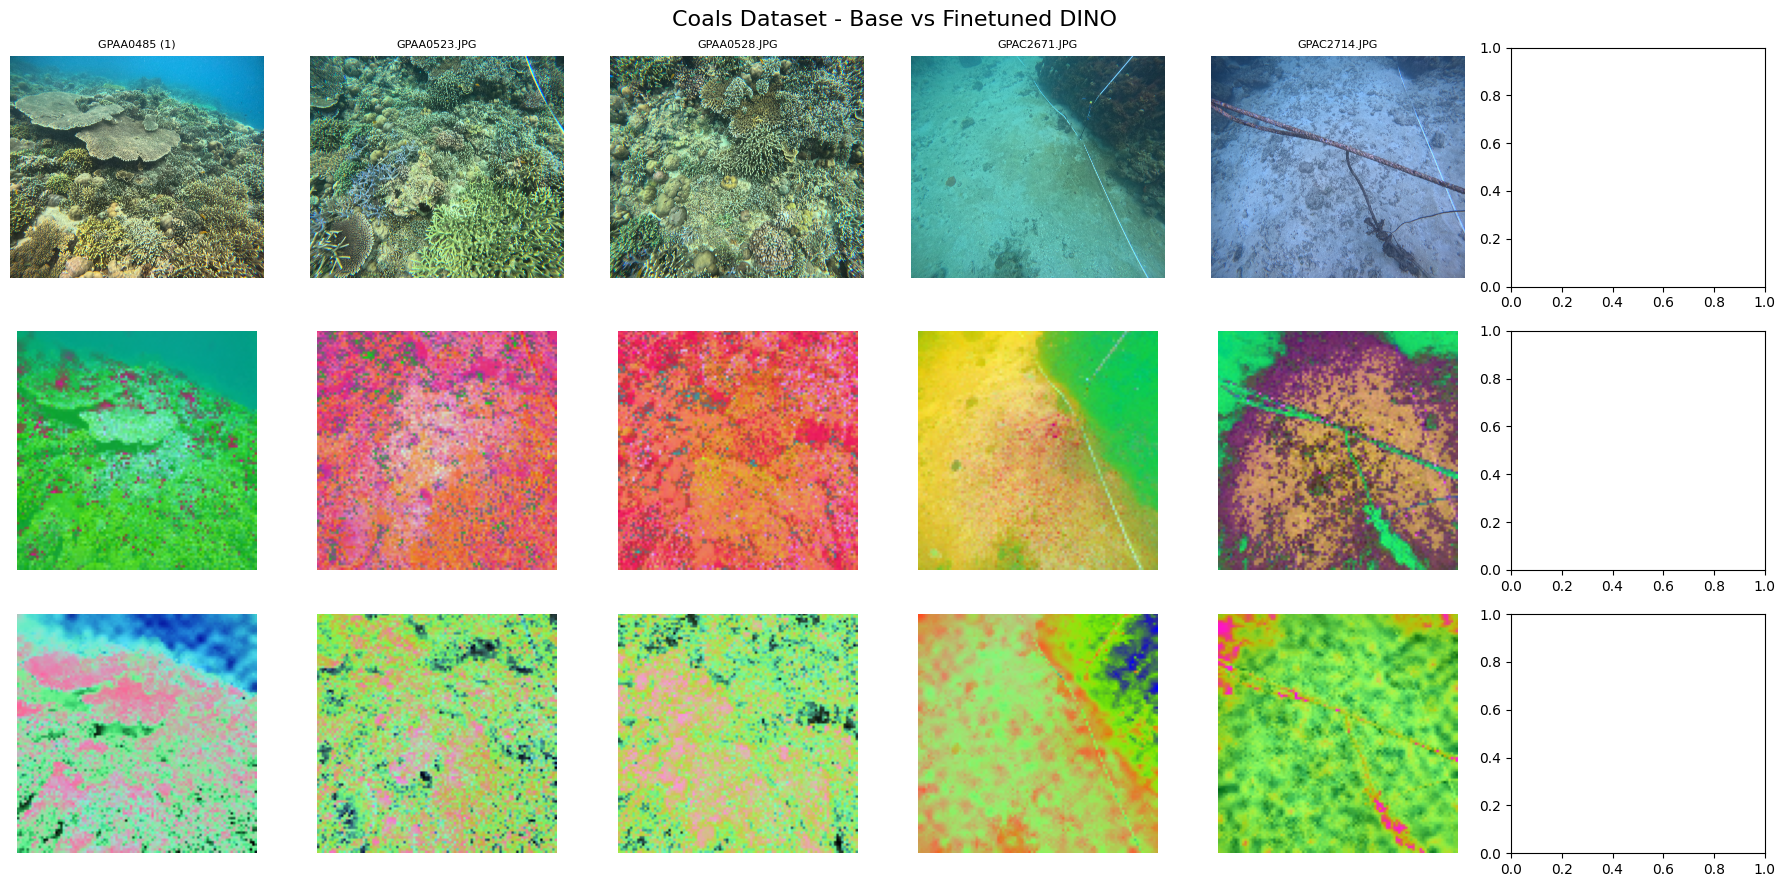

Processed 5 images from coals


In [3]:
# Dataset 1: Coals
coals_paths = sorted(Path('coals').glob('*.JPG'))[:6]
fig = visualize_comparison(coals_paths, base_model, finetuned_model, 'Coals Dataset - Base vs Finetuned DINO')
plt.savefig('comparison_coals.png', dpi=200, bbox_inches='tight')
plt.show()
print(f"Processed {len(coals_paths)} images from coals")


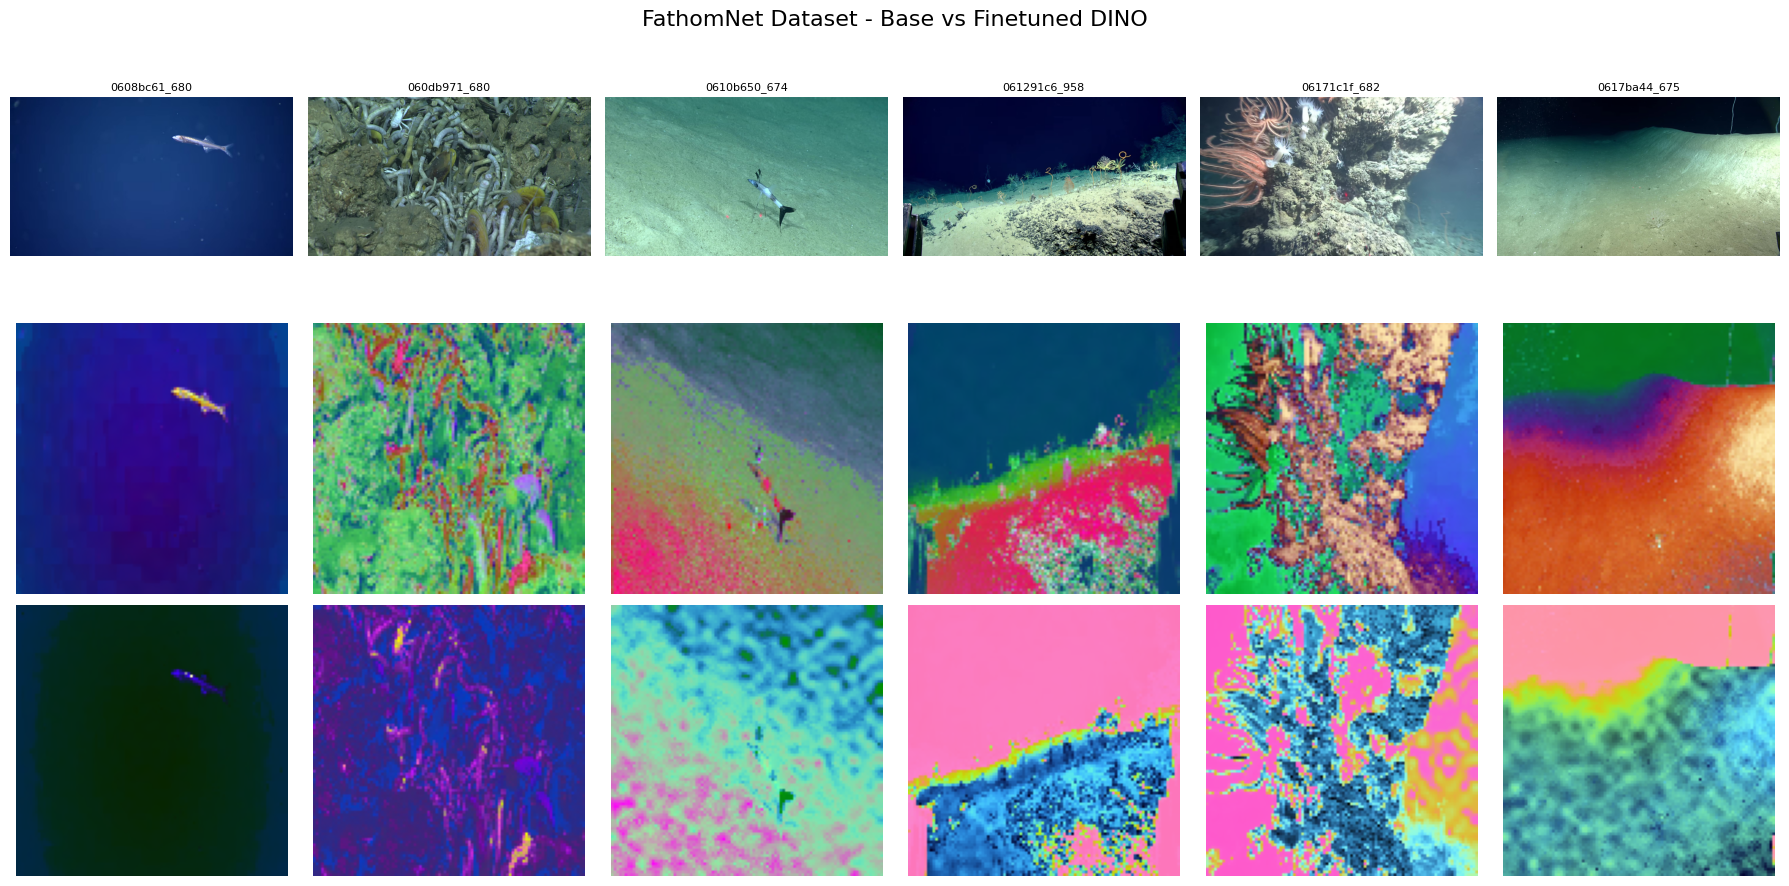

Processed 6 images from fathomnet_images


In [4]:
# Dataset 2: FathomNet
fathomnet_paths = sorted(Path('fathomnet_images/all').glob('*.jpg'))[302:308]
fig = visualize_comparison(fathomnet_paths, base_model, finetuned_model, 'FathomNet Dataset - Base vs Finetuned DINO')
plt.savefig('comparison_fathomnet.png', dpi=200, bbox_inches='tight')
plt.show()
print(f"Processed {len(fathomnet_paths)} images from fathomnet_images")


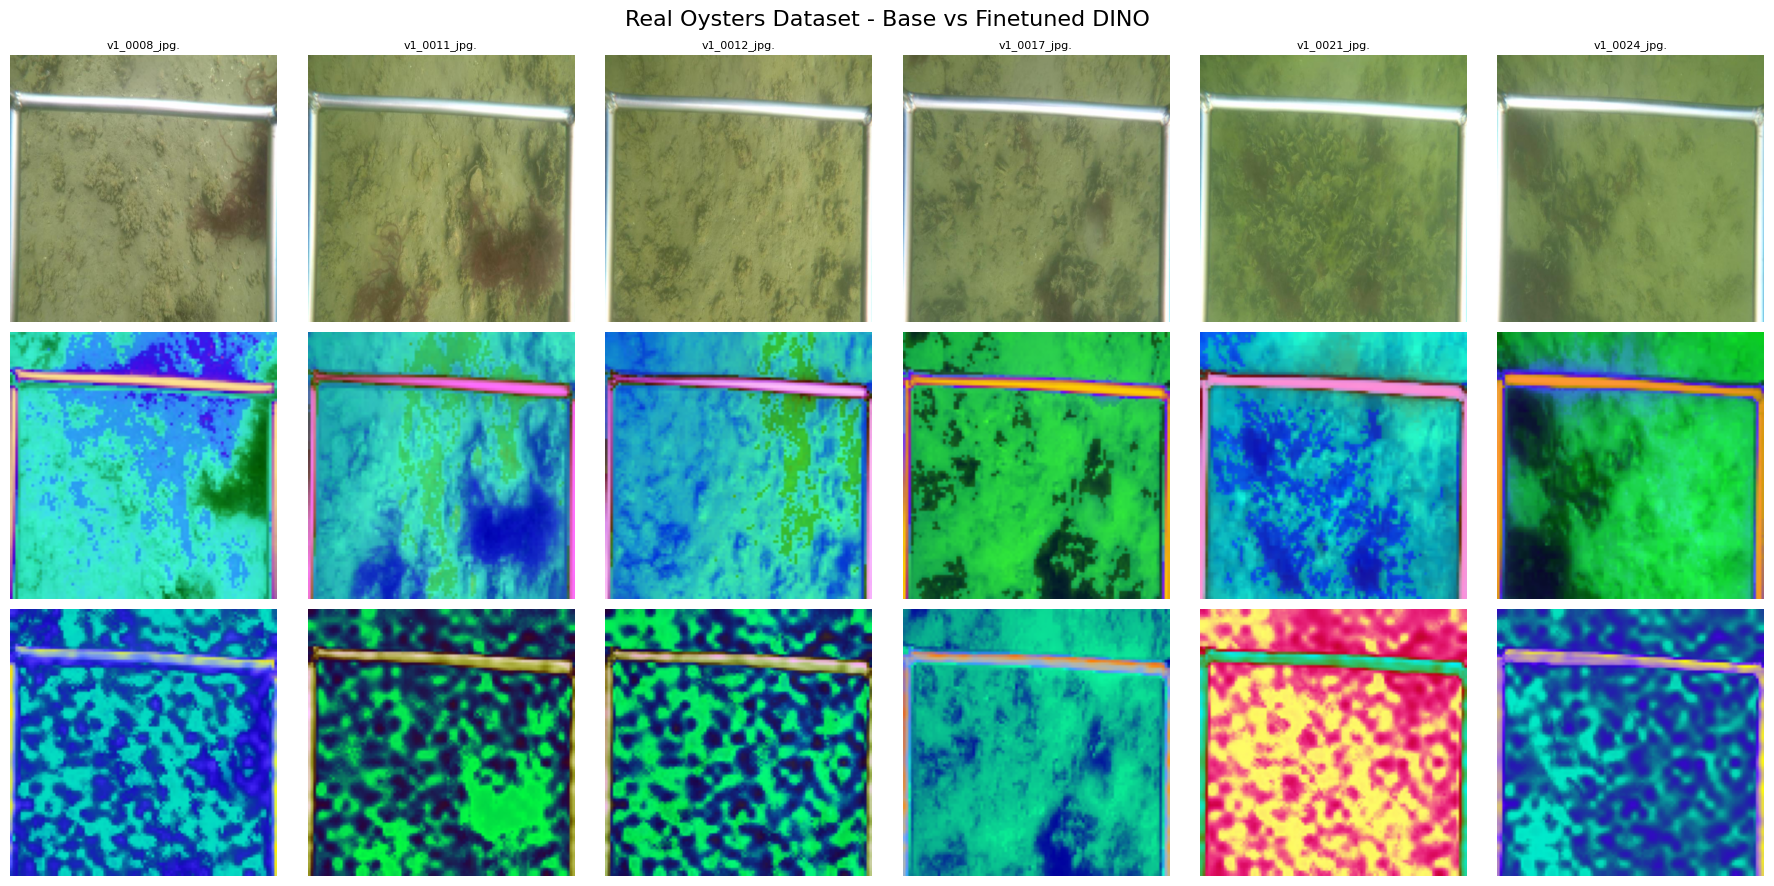

Processed 6 images from real-oysters-1/train


In [5]:
# Dataset 3: Real Oysters
oyster_paths = sorted(Path('real-oysters-1/train').glob('*.jpg'))[:6]
fig = visualize_comparison(oyster_paths, base_model, finetuned_model, 'Real Oysters Dataset - Base vs Finetuned DINO')
plt.savefig('comparison_oysters.png', dpi=200, bbox_inches='tight')
plt.show()
print(f"Processed {len(oyster_paths)} images from real-oysters-1/train")
